# Traffic signs detection project #
Section 5 of our project: using an external ResNet.

In [29]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

path_base = os.getcwd() + "\\databases"
train, test = np.load(os.path.join(path_base,'train_color.npy')), np.load(os.path.join(path_base,'test_color.npy'))
train = train.astype("float32") / 255
train = np.expand_dims(train, -1)
test = test.astype("float32") / 255
test = np.expand_dims(test, -1)



In [120]:
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTrain4170Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Train_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Train_classes.append(i)

#get classification from file
path_pict = os.getcwd() + "\\pictures"

f = open(path_pict + "\\TsignRecgTest1994Annotation.txt", "r")
str = f.read()

lines = str.split("\n")
arr = []
for line in lines:
    arr.append(int(line.split(";")[7]))
    
Test_classes = []
for i in range(58):
    for k in range(arr.count(i)):
        Test_classes.append(i)
Test_classes = np.array(Test_classes)
Train_classes = np.array(Train_classes)


large_train_classes = []
for i in range(0, 4170*3):
    large_train_classes.append(Train_classes[i % 4170])

# Now we augmentate the images in the array in order to get a larger data set and try to reach higher accuracy percentage:
from scipy import ndimage

large_train = []

for i in range(0, 4170):
    large_train.append(train[i])
for i in range(0, 4170):
    large_train.append(ndimage.rotate(train[i], 20, reshape=False))
for i in range(0, 4170):
    large_train.append(ndimage.rotate(train[i], -20, reshape=False))

large_train = np.array(large_train)

In [172]:
# Now we use the ResNet. We tries using ResNet50 and ResNet101 as well but we got the best score with ResNet152.

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.applications import VGG19

from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
        
num_classes = 58
input_shape = (45, 45, 3)
y_train = keras.utils.to_categorical(Train_classes, num_classes)
y_test = keras.utils.to_categorical(Test_classes, num_classes)

# Load model without classifier layers:
model = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = False

# Add new classifier layers:
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
drop = layers.Dropout(0.2)(class1)
bn = layers.BatchNormalization()(drop)
output = Dense(num_classes, activation='softmax')(bn)

# Define new model and summarize it:
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 45, 45, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 45, 45, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 45, 45, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 22, 22, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 22, 22, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 22, 22, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 11, 11, 128)       0  

In [173]:
batch_size = 128
epochs = 5
model.compile(optimizer='Adam',
  loss="categorical_crossentropy",
  metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/5
30/30 [==============================] - 87s 3s/step - loss: 1.8582 - categorical_accuracy: 0.5246 - val_loss: 3.7585 - val_categorical_accuracy: 0.2710
Epoch 2/5
30/30 [==============================] - 93s 3s/step - loss: 0.7293 - categorical_accuracy: 0.7927 - val_loss: 3.5201 - val_categorical_accuracy: 0.3309
Epoch 3/5
30/30 [==============================] - 84s 3s/step - loss: 0.4377 - categorical_accuracy: 0.8796 - val_loss: 3.3210 - val_categorical_accuracy: 0.3333
Epoch 4/5
30/30 [==============================] - 83s 3s/step - loss: 0.2985 - categorical_accuracy: 0.9195 - val_loss: 3.3515 - val_categorical_accuracy: 0.3333
Epoch 5/5
30/30 [==============================] - 82s 3s/step - loss: 0.2238 - categorical_accuracy: 0.9416 - val_loss: 3.4321 - val_categorical_accuracy: 0.3333
Test loss: 2.7724764347076416
Test accuracy: 0.4109109044075012


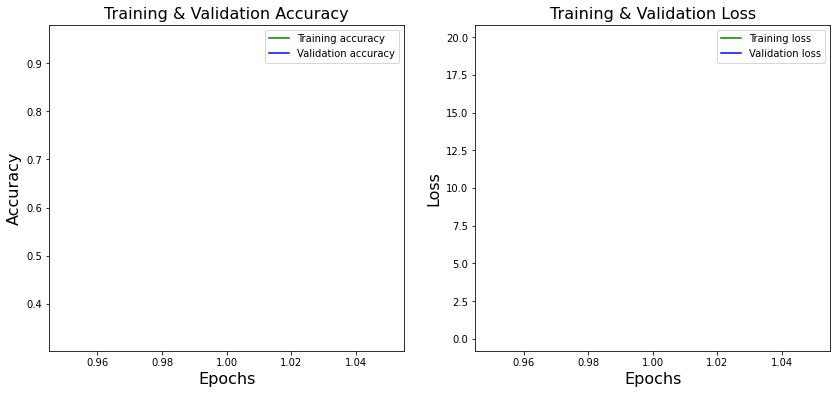

In [165]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['categorical_accuracy']
val_accuracy = history_dict['val_categorical_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'g', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'g', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

plt.show()

# In conclusion:
1. We managed to get 50% accuracy score on a 4170 pictures dataset of traffic signs (only train. Combined with the test set we have 6000 images). 
2. We decided to increase our dataset by rotating each image 20 degrees and 340 degrees - we got now 4170*3=12510 images for our train set.
3. We ran our Neural Net and got 80% accuracy now.
4. We tried using a Keras ResNet and comparing to our net, it doesn't work so well with our dataset.